[*********************100%***********************]  1 of 1 completed
6976.T
buy in 2020-11-09 00:00:00 at 4055.0
up stopline1 in 2020-11-20 00:00:00 at 4055.0
up stopline2 in 2020-11-26 00:00:00 at 4257.75
up stopline3 in 2021-01-05 00:00:00 at 4460.5
up stopline4 in 2021-01-13 00:00:00 at 4632.5
up stopline5 in 2021-01-20 00:00:00 at 4880.0
up stopline6 in 2021-01-20 00:00:00 at 4880.0
up stopline6 in 2021-01-21 00:00:00 at 5000.0
Date:261 Last Day Buy at the price 5990.0


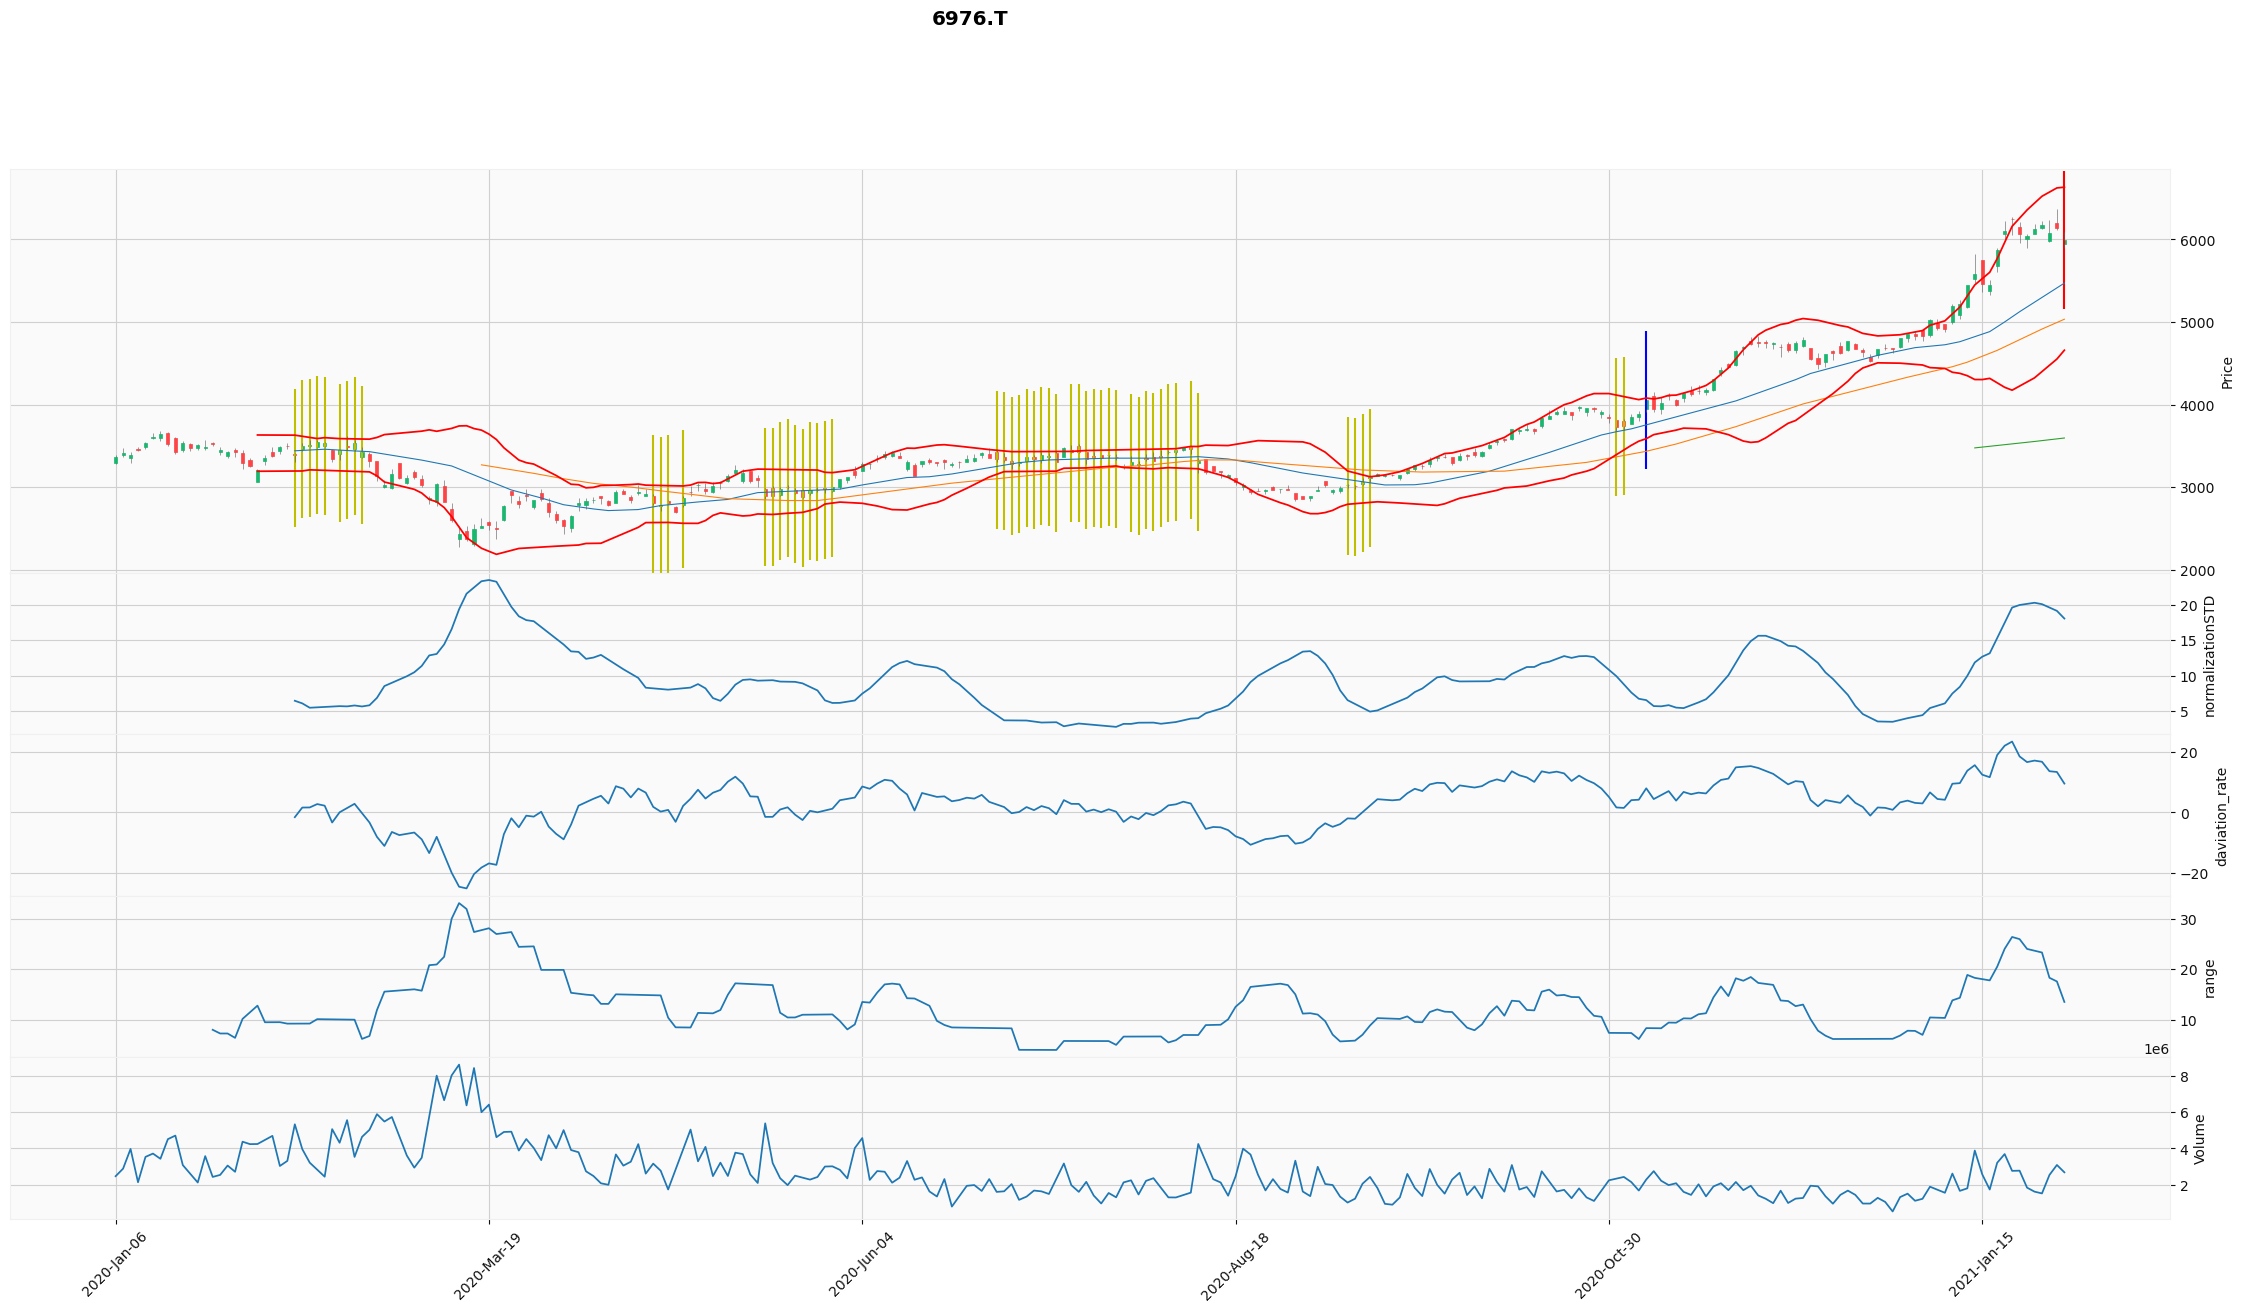

[*********************100%***********************]  1 of 1 completed
6036.T
buy in 2020-05-29 00:00:00 at 812.2177124023438
up stopline1 in 2020-06-03 00:00:00 at 812.2177124023438
up stopline2 in 2020-06-03 00:00:00 at 852.8285980224609


NameError: name 'buypoint' is not defined

In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpl
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
'''
戦略
ボラティリティー低下でシグナルを出す
上放れした時点で買い
ストップは順次あげていく
'''

#install symbols nasdaq100の銘柄コード
df = pd.read_csv('../symbols/nasdaq100.csv')

# sign = []
# for symbol in df['symbol']:
#     sign.append(symbol)
    

sign = ['6976.T','6036.T','ATVI', 'AMD', 'ALXN', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AMGN', 'ADI'
        , 'ANSYS', 'ANSS', 'AAPL', 'AMAT', 'TEAM', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BKNG'
        , 'AVGO','CDNS', 'CDW', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTSH', 'CMCSA'
        , 'CPRT', 'COST', 'CSX', 'DXCM', 'DOCU', 'DLTR', 'EBAY', 'EA', 'EXC', 'FB', 'FAST'
        , 'FISV', 'FOXA', 'FOX', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD'
        , 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MTCH', 'MXIM', 'MELI', 'MCHP', 'MU'
        , 'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NTES', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'OKTA', 'PCAR', 'PAYX'
        , 'PYPL', 'PTON', 'PEP', 'PDD', 'QUALCOMM', 'QCOM', 'REGN', 'ROST', 'SGEN', 'SIRI', 'SWKS', 'SPLK'
        , 'SBUX', 'SNPS', 'TMUS', 'TSLA', 'TXN', 'TCOM', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'XEL', 'XLNX'
        , 'ZM']
# # #'4477.T',
    

totalresult = []

for i in sign:
    stock_code = i 
    start = '2020-01-01'
    end = '2021-02-02'
    df = yf.download(stock_code, start, end, interval='1d') 
    if df.empty:
        print('{} is empty'.format(stock_code))
        results = []
        resultNum = 7
        for num in range(resultNum):
            results.append(np.nan)
        totalresult.append(results)
        continue
        
    
    
    print(i)
    term=81
    # chek the highest price in the past {term} times
    df['Highest'+str(term)] = df.iloc[:, 4].rolling(window=term).max()
#     print(df.head())
    
        
    
    # calculation SMA
    short_sma = 25
    long_sma = 50
    verylong_sma = 250
    #'term'日間の移動平均線
    df['SMA'+str(short_sma)] = df['Adj Close'].rolling(window=short_sma).mean()
    df['SMA'+str(long_sma)] = df['Adj Close'].rolling(window=long_sma).mean()
    df['SMA'+str(verylong_sma)] = df['Adj Close'].rolling(window=verylong_sma).mean()
      
    #slope of the sma
    def diff(x):
        return x[-1] - x[0]
    trend_term = 2
    df['SMA Trend'] = df['SMA'+str(short_sma)].rolling(window=trend_term).apply(diff)
    
    
    # caluculation ATR
    h, l, c_prev = df['High'], df['Low'], pd.Series(df['Close']).shift(1)
    tr = np.max([h - l, (c_prev - h).abs(), (c_prev - l).abs()], axis=0)
    atr = pd.Series(tr).rolling(14).mean().bfill().values
    
    # caluculation range
    df['mean'+str(14)] = df.iloc[:, 4].rolling(window=14).mean()
    df['Highest'+str(14)] = df.iloc[:, 4].rolling(window=14).max()
    df['Lowest'+str(14)] = df.iloc[:, 4].rolling(window=14).min()
    df['range'+str(14)] = 100 * (df['Highest'+str(14)] - df['Lowest'+str(14)] )/ df['mean'+str(14)]
    
    
    
    
     # 損切り率
    stopLoss = 0.94
    
    # signal 判断
    signal_arart = 0
 
    
    #買い日と売り日
    buy_days = []
    sell_days = []
    signal_days = []
    
    #holding period list
    holding_period_list = []


    #calucurate Bband
    df['MA'] = df['Adj Close'].rolling(window=20).mean()
    df['STD'] = df['Adj Close'].rolling(window=20).std()
    df['Upper'] = df['MA'] + (df['STD'] * 2)
    df['Lower'] = df['MA'] - (df['STD'] * 2)
    
    #daviation_rate
    df['daviation_rate'] = 100 * (df['Adj Close'] - df['SMA'+str(short_sma)]) / df['SMA'+str(short_sma)]

    #Standard deviation normalization
    df['Standard_deviation_normalization'] = 100 * 2 * df['STD'] / df['SMA'+str(short_sma)]
   
    buy_position = False
    percentChange = []
    for i in range(1, len(df)):
        close = df['Adj Close'][i]
        STD = df['STD'][i]
        high_price = df['High'][i]
        low_price = df['Low'][i]
        open_price = df['Open'][i]
        sma = df['SMA'+str(short_sma)][i]
        SDN = df['Standard_deviation_normalization'][i]
        daviation_rate = df['daviation_rate'][i]
        Highest = df['Highest'+str(term)][i-1]
        

    
        if np.isnan(df['MA'][i]) == False:
            if buy_position == False and SDN < 10 and -3 < daviation_rate < 3 :
#                 print('low volatility')
# and close > 0.95 * Highest
                signalday = pd.to_datetime(df.index[i])
                signal_days.append(signalday)
#                 print(signalday)
                signal_arart = 1
                signal_point = i
        
        if signal_arart == 1 and i - signal_point < 7 and close > Highest * 1.02 and buy_position == False:
            buy_position = True
            buyday = pd.to_datetime(df.index[i])
            buy_days.append(buyday)
            buy_price = close
            buy_stopLine = close * stopLoss
            stop_point = i
            current_stop_level = 0
            print('buy in {} at {}'.format(buyday,buy_price))
            signal_arart = 0
           
        
        #adjustment stopline
        if buy_position == True and close > buy_price * 1.05 and current_stop_level == 0:
            buy_stopLine = buy_price
            current_stop_level = 1
            stop_point = i
            print('up stopline1 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.1 and current_stop_level == 1:
            buy_stopLine = buy_price * 1.05
            current_stop_level = 2
            stop_point = i
            print('up stopline2 in {} at {}'.format(df.index[i],buy_stopLine))
           
            
        if buy_position == True and close > buy_price * 1.2 and current_stop_level == 2:
            buy_stopLine = buy_price * 1.1
            current_stop_level = 3
            stop_point = i
            print('up stopline3 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.3 and current_stop_level == 3:
            buy_stopLine = close * 0.85
            current_stop_level = 4
            stop_point = i
            print('up stopline4 in {} at {}'.format(df.index[i],buy_stopLine))
            
        if buy_position == True and close > buy_price * 1.5 and current_stop_level == 4:
            buy_stopLine = close * 0.8
            current_stop_level = 5  
            stop_point = i
            print('up stopline5 in {} at {}'.format(df.index[i],buy_stopLine))
            
            
        if buy_position == True and close > Highest and current_stop_level == 5:
            buy_stopLine = close * 0.8
            current_stop_level = 5  
            stop_point = i
            print('up stopline6 in {} at {}'.format(df.index[i],buy_stopLine))
            
            
            
         # 損切り or Profit taking
        if buy_position == True and open_price < buy_stopLine and i != stop_point :
            buy_position = False 
            percent = (open_price/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            holding_period = sellday - buyday
            print('sell in {} at {} | profit_one is {}'.format(sellday,open_price,percent))
            
        elif buy_position == True and close < buy_stopLine and i != buypoint:
            buy_position = False 
            percent = (buy_stopLine/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            holding_period = sellday - buyday
            holding_period_list.append(holding_period.days)
            print('sell in {} at {} | profit_two is {}'.format(sellday,buy_stopLine,percent))

        #  最終日にまだ持ってたら利確する
        if i == (len(df)-1) and buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            holding_period = sellday - buyday
            holding_period_list.append(holding_period.days)
            print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

       
    # statistic
#     ------------------------------------------
    gains = 0
    losses = 0
    numlosses = 0
    numgains = 0
    total_return = 1


    for i in percentChange:
        if i > 0:
            numgains += 1
            gains += i
        else:
            numlosses += 1
            losses += i
        total_return = total_return * ((i / 100) + 1)
        
        
    total_return = round((total_return - 1)*100, 2)
    if numgains > 0:
        ave_gain = gains / numgains
#         max_return = max(percentChange)
    else:
        ave_gain = 0
        max_return = 'unknown'
    
    if numlosses > 0:
        ave_loss = losses / numlosses
#         max_loss = min(percentChange)
        risk_reward_retio = - ave_gain / ave_loss
    else:
        ave_loss = 0
        max_loss = 'unknown'
        risk_reward_retio = 'inf'
    
    if numgains > 0 or numlosses > 0:
        batting_retio = numgains / (numgains + numlosses)
    else:
        batting_retio = 0
    
    trades = numgains + numlosses
    ave_total = ave_gain * batting_retio + ave_loss * (1 - batting_retio)
    
    #average holding period
    if len(holding_period_list) != 0:   
        average_holding_period = sum(holding_period_list)/len(holding_period_list)
    

    results = [numgains+numlosses, round(total_return,2), round(ave_gain,2), round(ave_loss,2)
               ,round(batting_retio,2) ,round(ave_total,2) ,round(average_holding_period,2)]
    
    if not results is None:
         totalresult.append(results)

    #plot figure --------------------------------------------------------- 
    
#     make figure
    df['70'] = 70
    df['30'] = 30
    df['50'] = 50
    df['0'] = 0
    
    isSignalExist = False
    isBuySignalExist = False
    isSellSignalExist = False
    
    signal_signals = []
    for i in df.index:
        if i in signal_days:
            isSignalExist = True
            signal_signals.append(df['Adj Close'][i])
        else:
            signal_signals.append(np.nan)
            
    buy_signals = []
    for i in df.index:
        if i in buy_days:
            isBuySignalExist = True
            buy_signals.append(df['Adj Close'][i])
        else:
            buy_signals.append(np.nan)
            
    sell_signals = []
    for i in df.index:
        if i in sell_days:
            isSellSignalExist = True
            sell_signals.append(df['Adj Close'][i])
        else:
            sell_signals.append(np.nan)
            
           
    
    apds = [
    mpl.make_addplot( df['Volume'] , panel=4, ylabel='Volume'),
    mpl.make_addplot(df['Upper'], type='line' ,color="r"),
    mpl.make_addplot(df['Lower'], type='line',color="r"),
    mpl.make_addplot(df['Standard_deviation_normalization'], panel=1, type='line', ylabel='normalizationSTD'),
    mpl.make_addplot( df['daviation_rate'] , panel=2, type='line', ylabel='daviation_rate'),
    mpl.make_addplot( df['range'+str(14)] , panel=3, type='line', ylabel='range'),
    # mpl.make_addplot(signal_signals, type='scatter', markersize=10000, marker='|', color="y"),
    # mpl.make_addplot(buy_signals, type='scatter', markersize=10000, marker='|', color="b"),
    # mpl.make_addplot(sell_signals, type='scatter', markersize=10000, marker='|', color="r"),
    ]

    if isSignalExist:
        apds.append(mpl.make_addplot(signal_signals, type='scatter', markersize=10000, marker='|', color="y"))
    if isBuySignalExist:
        apds.append(mpl.make_addplot(buy_signals, type='scatter', markersize=10000, marker='|', color="b"))
    if isSellSignalExist:
        apds.append(mpl.make_addplot(sell_signals, type='scatter', markersize=10000, marker='|', color="r"))

    if not sell_signals :
        print(len(sell_signals))
        print('all nan')
        continue
#     print(all([i == np.nan for i in buy_signals]))
#     if np.isnan(all(buy_signals)) == False:
#         print('pppppp')
# #     print('length of the array')
#     print(len(buy_signals))
#     print(buy_signals)
#     print(len(sell_signals))
    
    fig = mpl.plot(df, type='candle',figsize=(30, 15), style='yahoo',mav=(short_sma, long_sma, verylong_sma)
                       , addplot=apds, title=str(stock_code))



columns = ['trades', 'Total return', 'Average Gain', 'Average Loss', '勝率' ,'Average gain and profit','average holding period']
df = pd.DataFrame(totalresult, columns=columns, index = sign)
df.to_csv('./volatility_result.csv')

print(df)
        